<a href="https://colab.research.google.com/github/hackerpranavpandey/SOI_Mission_Mars_Terrain/blob/main/Train_CNN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Mission_Mars/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
import os
import torch.nn as nn
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv(path)

In [ ]:
import numpy as np
print(f"the shape of label csv fie is : {np.shape(df)}")
print(f" all the unique labels present in the dataset is:{np.unique(df.iloc[:,1:])}")

the shape of label csv fie is : (6201, 2)
 all the unique labels present in the dataset is:['bright dune' 'crater' 'dark dune' 'impact ejecta' 'other' 'slope streak'
 'spider' 'swiss cheese']


In [ ]:
print(df.iloc[:,1:].value_counts())

Class        
other            3651
crater           1062
bright dune       597
slope streak      335
swiss cheese      223
dark dune         216
spider             66
impact ejecta      51
Name: count, dtype: int64


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
images=[]
labels=[]
def image_process():
  images_path='/content/drive/MyDrive/Mission_Mars/train_dataset'
  for image_path in os.listdir(images_path):
    label=image_path.split('.')[0]
    label=int(label)-1
    label=df.iloc[label,1:]
    labels.append(label[0])
    image_name=os.path.join(images_path,image_path)
    image_array=cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    images.append(image_array)
image_process()

other


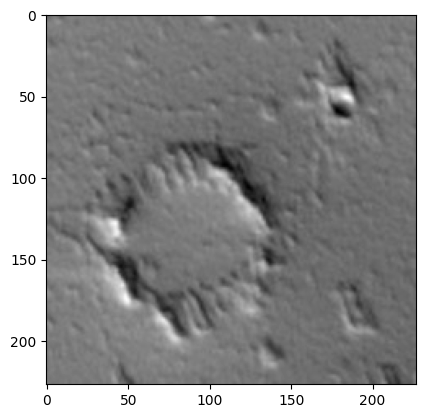

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[246],cmap="gray")
print(labels[246])

In [ ]:
## resizing the image
## also converting it to rgb format
resized_images=[]
def reshape():
  for image in images:
    new_array=np.array(cv2.resize(image,(216, 216)))
    rgb_array = np.stack((new_array,)*3,axis=-1)
    resized_images.append(rgb_array)
reshape()

In [ ]:
np.shape(resized_images)

(6201, 216, 216, 3)

In [ ]:
## now lets do some data augementation for images with less  number to decrease the model underfitting
def image_augmentation():
  t=len(resized_images)
  for i in range(0,t):
    rotated_array_90=cv2.rotate(resized_images[i], cv2.ROTATE_90_CLOCKWISE)
    rotate_180=cv2.rotate(resized_images[i], cv2.ROTATE_180)
    rotated_array_270 = cv2.rotate(resized_images[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
    if labels[i]=='crater':
      resized_images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="bright dune" or labels[i]=="slope streak" or labels[i]=="swiss cheese" or labels[i]=="dark dune":
      resized_images.append(rotated_array_90)
      labels.append(labels[i])
      resized_images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="spider" or labels[i]=="impact ejecta":
      resized_images.append(rotated_array_90)
      labels.append(labels[i])
      resized_images.append(rotate_180)
      labels.append(labels[i])
      resized_images.append(rotated_array_270)
      labels.append(labels[i])
image_augmentation()

In [ ]:
resized_images=np.array(resized_images)
labels=np.array(labels)

In [ ]:
labels[0],np.shape(labels),np.shape(resized_images)

('swiss cheese', (10356,), (10356, 216, 216, 3))

## Lets do some label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(labels)
encoded_mapping = {label: encoded_value for label, encoded_value in zip(target,labels)}
print(encoded_mapping)

{7: 'swiss cheese', 4: 'other', 0: 'bright dune', 1: 'crater', 3: 'impact ejecta', 2: 'dark dune', 5: 'slope streak', 6: 'spider'}


##Let's split the dataset into train and validation

In [ ]:
resized_images=np.array(resized_images)
X_train, X_val, y_train,y_val =train_test_split(resized_images, target, test_size=0.2, random_state=42)

In [ ]:
np.shape(X_train),np.shape(X_val)

((8284, 216, 216, 3), (2072, 216, 216, 3))

## To use Pytorch need to convert them to tensors

In [ ]:
from torchvision import transforms
import torch
from torch.utils.data import Dataset
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
class CustomDataset(Dataset):
  def __init__(self,image,label,transform=None):
    self.image=image
    self.label=label
    self.transform=transform
  def __len__(self):
    return len(self.image)
  def __getitem__(self,idx):
    image=self.image[idx]
    label=self.label[idx]
    image=Image.fromarray(image)
    if self.transform is not None:
      image=self.transform(image)
    return image,label
device

device(type='cuda')

In [ ]:
from torch.utils.data import DataLoader
train_dataset=CustomDataset(X_train,y_train,transform=transform)
val_dataset=CustomDataset(X_val,y_val,transform)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [ ]:
for image,label in train_loader:
  print(image.shape,label.shape)
  break

torch.Size([32, 3, 256, 256]) torch.Size([32])


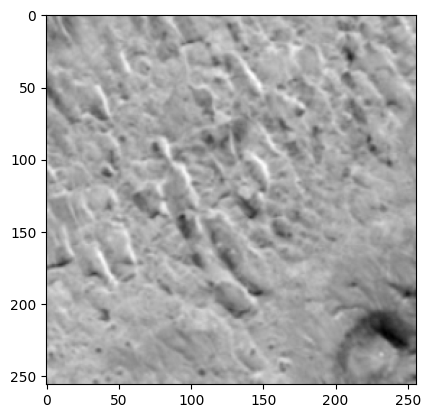

In [ ]:
for image,label in train_loader:
  plt.imshow(image[0][0],cmap="gray")
  break

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(3,6,5)
    self.pool1=nn.MaxPool2d(3,3)
    self.conv2=nn.Conv2d(6,16,3)
    self.pool2=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(16*41*41,584)
    self.fc2=nn.Linear(584,60)
    self.fc3=nn.Linear(60,8)
  def forward(self,x):
      x=self.conv1(x)
      x=F.relu(x)
      x=self.pool1(x)
      x=self.conv2(x)
      x=F.relu(x)
      x=self.pool2(x)
      x=x.view(-1,16*41*41)
      x=self.fc1(x)
      x=F.relu(x)
      x=self.fc2(x)
      x=F.relu(x)
      x=self.fc3(x)
      return x
cnn=CNN().to(device)
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=26896, out_features=584, bias=True)
  (fc2): Linear(in_features=584, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=8, bias=True)
)

In [ ]:
loss_function=nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(cnn.parameters(),lr=0.001)

In [ ]:
loss_function,optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [ ]:
from sklearn.metrics import confusion_matrix
for epoch in range(10):
  running_loss=0.0
  running_accuracy=0.0
  cnn.train()
  for image,label in train_loader:
    image=image.to(device)
    label=label.to(device)
    optimizer.zero_grad()
    output=cnn(image)
    loss=loss_function(output,label)
    loss.backward()
    optimizer.step()
    max_value,pred=torch.max(output,1)
    running_accuracy+=torch.sum(pred==label.data)
    running_loss+=loss.item()
  train_loss=running_loss/(len(train_loader.dataset))
  train_acc=running_accuracy/len(train_loader.dataset)
  cnn.eval()
  val_loss=0.0
  val_acc=0.0
  all_pred=[]
  all_label=[]
  with torch.no_grad():
    for image,label in val_loader:
      image=image.to(device)
      label=label.to(device)
      output=cnn(image)
      loss=loss_function(output,label)
      max_value,pred=torch.max(output,1)
      val_loss+=loss.item()
      val_acc+=torch.sum(pred==label.data)
      all_pred.extend(pred.cpu().numpy())
      all_label.extend(label.cpu().numpy())
  val_loss=val_loss/(len(val_loader.dataset))
  val_acc=val_acc/len(val_loader.dataset)
  if epoch==9:
    print(confusion_matrix(all_label,all_pred))
  print(f"Epoch {epoch+1},train_loss:{train_loss},train_acc:{train_acc},val_loss:{val_loss},val_acc:{val_acc}")

Epoch 1,train_loss:0.0006973389487553989,train_acc:0.9937228560447693,val_loss:0.07782645647245025,val_acc:0.7340733408927917
Epoch 2,train_loss:0.0007441271582612432,train_acc:0.9921535849571228,val_loss:0.055015599419826706,val_acc:0.7601351141929626
Epoch 3,train_loss:0.000832156643957424,train_acc:0.9929986000061035,val_loss:0.059156585067625674,val_acc:0.75
Epoch 4,train_loss:0.00016634047876884408,train_acc:0.998913586139679,val_loss:0.06702166720937118,val_acc:0.751447856426239
Epoch 5,train_loss:0.0016254976046782882,train_acc:0.9849107265472412,val_loss:0.05649591435796966,val_acc:0.7166988253593445
Epoch 6,train_loss:0.0017445415397265608,train_acc:0.9838242530822754,val_loss:0.061784062692787654,val_acc:0.7364864945411682
Epoch 7,train_loss:0.0005903070704387961,train_acc:0.9954128861427307,val_loss:0.06538425856287876,val_acc:0.7369691133499146
Epoch 8,train_loss:0.00029790013882359886,train_acc:0.9978271722793579,val_loss:0.06098272916087773,val_acc:0.7533783912658691
Epoc